<a href="https://colab.research.google.com/github/TheophileZuber/2024_MLEES/blob/main/ML_course_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The two models SoftMax regression and Random Forest script are in this notbook. The first two cells in the note book do not need to be ran, they just describ some of the preprocessing that was done to the real data and also how the synthetic data have been generated.

Data formating (DO NOT WORK WITH SYNTHETIC DATA)
No need of running

In [1]:
# Import necessary libraries
import os  # For file system operations
from datetime import datetime  # For working with dates and times
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
from sklearn.metrics import (  # Metrics for evaluating model performance
    accuracy_score,  # Calculates prediction accuracy
    classification_report,  # Provides detailed classification metrics
    confusion_matrix,  # Generates a confusion matrix
    ConfusionMatrixDisplay,  # Plots the confusion matrix
    matthews_corrcoef  # Computes Matthews correlation coefficient for classification tasks
)
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, train_test_split  # For cross-validation and splitting data
from sklearn.ensemble import RandomForestClassifier  # Random Forest algorithm for classification
import matplotlib.pyplot as plt  # For visualizations
import seaborn as sns  # Enhances plotting capabilities
import joblib  # For saving/loading Python objects like trained models
from google.colab import drive  # To interact with Google Drive in Google Colab

# Mount Google Drive to access datasets and save results
if not os.path.exists('/content/drive'):  # Check if the drive is already mounted
    drive.mount('/content/drive')  # Mount the drive if not already mounted
else:
    print("Drive is already mounted.")  # Skip mounting if already done

# Create an output directory for saving results
output_dir = "/content/drive/MyDrive/Model_results/RF/"  # Directory path for results
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist

# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/data/NoImputation.csv")  # Read the CSV file into a pandas DataFrame

# Preprocess the data
data['timestamp'] = pd.to_datetime(data['timestamp'])  # Convert 'timestamp' column to datetime objects
data['hour'] = data['timestamp'].dt.hour  # Extract the hour of the day from the timestamp
data['day_of_week'] = data['timestamp'].dt.dayofweek  # Extract the day of the week (0=Monday, 6=Sunday)

# Add cyclical features for time-based data
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)  # Sine transformation for hours
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)  # Cosine transformation for hours
data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)  # Sine transformation for days
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)  # Cosine transformation for days

# Sort the data for sequential processing
data.sort_values(by=['Ind_ID', 'timestamp'], inplace=True)  # Sort by individual ID and timestamp

# Drop columns that are unnecessary for modeling
data = data.drop(columns=["target_Grooming_actor", "Grooming_actor"])  # Remove specific irrelevant columns

# Define the group column and target columns
group_column = 'Ind_ID'  # Grouping variable (e.g., individual IDs)
target_columns = [col for col in data.columns if col.startswith('target_')]  # Identify target columns dynamically

# Define the feature columns
feature_columns = [
    'speed_ms', 'stepLenght', 'turnAngle_sin', 'turnAngle_cos',  # Basic movement features
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'  # Time-related features
] + list(data.columns[8:34])  # Dynamically include columns from index 8 to 34 which correspond to the landcover labels and behavior labels

# Ensure that target columns are detected
target_columns = [col for col in data.columns if col.startswith('target_')]  # Reconfirm target columns
print(f"Target columns found: {target_columns}")  # Display detected target columns

# Create a unified target class column
# This combines multiple one-hot-encoded target columns into a single column with class labels
data['target_class'] = data[target_columns].idxmax(axis=1)  # Pick the column with the maximum value as the target class (the values can only be 0 or 1)

# Verify that the target class column has been created
print(f"Target class column added: {data['target_class'].head()}")  # Display the first few rows of the new target class column

# Perform train-test split
train_data, test_data = train_test_split(  # Split data into training and testing sets
    data, test_size=0.2, random_state=42, stratify=data['target_class']  # Stratify to preserve class distribution
)

# Separate features (X) and target (y) for both training and testing sets
X_train = train_data[feature_columns]  # Features for training
y_train = train_data['target_class']  # Target variable for training
X_test = test_data[feature_columns]  # Features for testing
y_test = test_data['target_class']  # Target variable for testing

# Validate the shape of features and targets
assert X_train.shape[0] == y_train.shape[0], "Mismatch between X_train and y_train"  # Ensure row count matches
assert X_test.shape[0] == y_test.shape[0], "Mismatch between X_test and y_test"  # Ensure row count matches

# Display the shapes of the train and test datasets for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  # Print training set shape
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")  # Print testing set shape

# Extract unique classes and preserve their order
unique_classes = data['target_class'].unique()  # Get the unique classes in the dataset

# Map class names (labels) to numerical indices
class_mapping = {class_name: idx for idx, class_name in enumerate(sorted(unique_classes))}  # Create a mapping
print("Class Mapping:", class_mapping)  # Display the mapping from class names to indices


KeyboardInterrupt: 

How the synthetic data have been generated

In [ ]:
import numpy as np  # For numerical operations and random sampling
import pandas as pd  # For data manipulation and storage

# Function to generate synthetic data
def generate_synthetic_data(original_data, feature_columns, target_columns, n_samples):
    """
    Generates synthetic data based on the distributions in the original dataset.

    Parameters:
        original_data (pd.DataFrame): The original dataset used as a reference.
        feature_columns (list): List of feature column names to include in synthetic data.
        target_columns (list): List of target column names (one-hot encoded) to generate target data.
        n_samples (int): Number of synthetic samples to generate.

    Returns:
        pd.DataFrame: A synthetic dataset with features and target columns.
    """
    # Initialize an empty DataFrame for synthetic data
    synthetic_data = pd.DataFrame()

    # Generate synthetic features by sampling from the original dataset
    for column in feature_columns:
        if column in original_data.columns:
            # Sample with replacement from the original column
            synthetic_data[column] = np.random.choice(
                original_data[column], size=n_samples, replace=True
            )

    # Define subsets of feature columns for one-hot encoding groups
    group_1_cols = feature_columns[8:14]  # Group 1: Columns 8-13 (0-indexed)
    group_2_cols = feature_columns[14:31]  # Group 2: Columns 14-30 (0-indexed)

    # Helper function to generate one-hot encoded data for a group of columns
    def generate_one_hot_group(columns):
        """
        Generates one-hot encoded data ensuring mutual exclusivity within a group.

        Parameters:
            columns (list): List of column names in the group.

        Returns:
            pd.DataFrame: One-hot encoded synthetic data for the group.
        """
        group_data = np.zeros((n_samples, len(columns)))  # Initialize a zero matrix
        for i in range(n_samples):
            one_hot_index = np.random.choice(len(columns))  # Randomly select an index to activate
            group_data[i, one_hot_index] = 1  # Set the selected index to 1
        return pd.DataFrame(group_data, columns=columns)  # Convert to DataFrame with column names

    # Generate synthetic one-hot encoded data for both groups
    synthetic_group_1 = generate_one_hot_group(group_1_cols)  # Group 1 one-hot data
    synthetic_group_2 = generate_one_hot_group(group_2_cols)  # Group 2 one-hot data

    # Add generated one-hot groups to the synthetic dataset
    synthetic_data = pd.concat([synthetic_data, synthetic_group_1, synthetic_group_2], axis=1)

    # Generate synthetic target data
    target_probs = original_data[target_columns].mean()  # Calculate the mean probabilities for each target
    target_samples = np.random.multinomial(1, target_probs, size=n_samples)  # Sample targets using multinomial distribution
    target_one_hot = pd.DataFrame(target_samples, columns=target_columns)  # Convert samples to a DataFrame

    # Append the one-hot encoded target data to the synthetic dataset
    synthetic_data = pd.concat([synthetic_data, target_one_hot], axis=1)

    # Convert one-hot encoded targets to a single-column format
    synthetic_data['target_class'] = target_one_hot.idxmax(axis=1)  # Use the column with the highest value as the target class

    return synthetic_data  # Return the final synthetic dataset

# Number of synthetic samples to generate
n_samples = 20000

# Generate synthetic data using the defined function
synthetic_data = generate_synthetic_data(data, feature_columns, target_columns, n_samples)

# Separate synthetic data into features (X) and target (y)
X_synthetic = synthetic_data[feature_columns]  # Feature columns
y_synthetic = synthetic_data['target_class']  # Target column

# Display a preview of the synthetic features and target
print("Synthetic Features:")
print(X_synthetic.head())  # Display the first few rows of synthetic features
print("\nSynthetic Target:")
print(y_synthetic.head())  # Display the first few rows of synthetic target

# Save the synthetic data to CSV files
X_synthetic.to_csv("/content/drive/MyDrive/data/synthetic_features.csv", index=False)  # Save features to a CSV file
y_synthetic.to_csv("/content/drive/MyDrive/data/synthetic_target.csv", index=False)    # Save target to a separate CSV file

# Alternatively, save the entire synthetic dataset in a single file
synthetic_data.to_csv("/content/drive/MyDrive/data/synthetic_data.csv", index=False)   # Save combined features and target

# Confirm that the synthetic data has been saved
print("Synthetic data saved as CSV files.")


SoftMax regression model

Preprocessing

In [1]:
import os  # For file and directory operations
import numpy as np  # For numerical operations and metrics calculations
import pandas as pd  # For data manipulation and storage
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay, matthews_corrcoef
)  # For model evaluation
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV  # For data splitting and cross-validation
from sklearn.linear_model import LogisticRegression  # For the softmax regression model
import joblib  # For saving and loading models
import matplotlib.pyplot as plt  # For plotting and saving figures
from google.colab import drive  # To interact with Google Drive in Google Colab

# Mount Google Drive to access datasets and save results
if not os.path.exists('/content/drive'):  # Check if the drive is already mounted
    drive.mount('/content/drive')  # Mount the drive if not already mounted
else:
    print("Drive is already mounted.")  # Skip mounting if already done

# Create a directory to save results
results_dir = "/content/drive/MyDrive/Model_results/Softmax/"
os.makedirs(results_dir, exist_ok=True)  # Ensures the directory exists

# Load synthetic data generated from the previous script
synthetic_data_path = "/content/drive/MyDrive/data/synthetic_data.csv"
if os.path.exists(synthetic_data_path):
    data = pd.read_csv(synthetic_data_path)
    print("Synthetic data loaded successfully.")
else:
    raise FileNotFoundError("Synthetic data file not found.")

# Define features and target columns
feature_columns = [
    'speed_ms', 'stepLenght', 'turnAngle_sin', 'turnAngle_cos',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
] + [col for col in data.columns if col.startswith('feature_')]  # Includes any additional feature columns

target_columns = [col for col in data.columns if col.startswith('target_')]  # Identify one-hot encoded target columns

# Convert target columns to numeric type to ensure compatibility for further processing
for column in target_columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')  # Replace invalid values with NaN if any

# Combine one-hot target columns into a single target class column
data['target_class'] = data[target_columns].idxmax(axis=1)  # Selects the column with the maximum value in each row

# Prepare data for modeling
X = data[feature_columns]  # Features
y = data['target_class']  # Target

# Train-test split with stratification to preserve class distribution
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target_class'])
X_train = train_data[feature_columns]
y_train = train_data['target_class']
X_test = test_data[feature_columns]
y_test = test_data['target_class']

# Define cross-validation strategy
n_splits = 16  # Number of splits for StratifiedGroupKFold
skf = StratifiedGroupKFold(n_splits=n_splits)  # Ensures balanced class distribution in each fold

# Define parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'saga', 'newton-cg', 'liblinear'],  # Optimization solvers
    'penalty': ['l2', 'elasticnet'],  # Regularization methods
    'tol': [1e-4, 1e-3, 1e-2],  # Convergence tolerance
    'fit_intercept': [True, False],  # Whether to fit the intercept
    'class_weight': [None, 'balanced']  # Handling of class imbalance
}


Mounted at /content/drive
Synthetic data loaded successfully.


Model initialisation and GridSearch

In [3]:

# Initialize Softmax Regression model
softmax_model = LogisticRegression(
    multi_class='multinomial',  # Enables softmax regression for multiclass classification
    max_iter=1000,  # Maximum number of iterations for solver convergence
    class_weight="balanced",  # Handles class imbalance by weighting classes inversely proportional to their frequencies
    random_state=42  # Ensures reproducibility
)

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=softmax_model,
    param_grid=param_grid,
    cv=skf.split(X_train, y_train, groups=train_data.index),  # Cross-validation strategy
    scoring='accuracy',  # Optimization metric
    n_jobs=-1  # Use all available CPU cores for faster processing
)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Output best parameters and the corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best model identified by grid search
best_softmax_model = grid_search.best_estimator_


Best Parameters: {'C': 0.01, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}
Best Cross-Validation Accuracy: 0.3693125


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
4800 fits failed out of a total of 7680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
960 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1267, in fit
    multi_class = _check_multi_class(multi_class, solver, len(self.clas

Fit and Crossvalidation with the best parameters for the model

In [4]:
# Evaluate the model using cross-validation
fold_accuracies = []  # Store accuracy for each fold
mcc_scores = []  # Store MCC for each fold

# Collect all true and predicted labels for a global confusion matrix
all_y_true = []
all_y_pred = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train, groups=train_data.index)):
    print(f"Fold {fold + 1}")
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model on the training portion of the fold
    best_softmax_model.fit(X_fold_train, y_fold_train)

    # Predict on the validation portion of the fold
    y_val_pred = best_softmax_model.predict(X_fold_val)

    # Collect true and predicted labels
    all_y_true.extend(y_fold_val)
    all_y_pred.extend(y_val_pred)

    # Evaluate metrics for the fold
    val_accuracy = accuracy_score(y_fold_val, y_val_pred)
    val_mcc = matthews_corrcoef(y_fold_val, y_val_pred)
    fold_accuracies.append(val_accuracy)
    mcc_scores.append(val_mcc)

Fold 1
Fold 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 3
Fold 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 5
Fold 6


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 7
Fold 8


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 9
Fold 10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 11
Fold 12


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 13
Fold 14


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 15
Fold 16


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Calculation and saving of the different performance measures

In [5]:

# Compute and save the global confusion matrix
global_conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
cm_display_global = ConfusionMatrixDisplay(confusion_matrix=global_conf_matrix)
cm_display_global.plot(cmap='viridis', colorbar=True)
plt.title("Global Confusion Matrix (Softmax Regression - CV)")
plt.savefig(os.path.join(results_dir, 'global_confusion_matrix_softmax.png'))
plt.close()

# Output global confusion matrix
print("Global Confusion Matrix (CV):")
print(global_conf_matrix)

# Save global confusion matrix to text
np.savetxt(os.path.join(results_dir, 'global_confusion_matrix_softmax.txt'), global_conf_matrix, fmt='%d')

# Compute mean validation accuracy and MCC
mean_val_accuracy = np.mean(fold_accuracies)
mean_mcc = np.mean(mcc_scores)
print(f"Mean Validation Accuracy (CV): {mean_val_accuracy:.2f}")
print(f"Mean MCC (CV): {mean_mcc:.2f}")

# Save validation metrics
cv_metrics_path = os.path.join(results_dir, 'cv_metrics.txt')
with open(cv_metrics_path, 'w') as f:
    f.write(f"Mean Validation Accuracy (CV): {mean_val_accuracy:.2f}\n")
    f.write(f"Mean MCC (CV): {mean_mcc:.2f}\n")

# Evaluate the model on the test set
y_test_pred = best_softmax_model.predict(X_test)

# Test set metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mcc = matthews_corrcoef(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test MCC: {test_mcc:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-Score: {test_f1:.2f}")

# Save test confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
cm_display_test.plot(cmap='viridis')
plt.title("Test Set Confusion Matrix (Softmax Regression)")
plt.savefig(os.path.join(results_dir, 'softmax_confusion_matrix_test.png'))
plt.close()

# Save classification report as CSV
classification_report_dict = classification_report(y_test, y_test_pred, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()
classification_report_df.to_csv(os.path.join(results_dir, 'classification_report.csv'), index=True)

# Save the final model
joblib.dump(best_softmax_model, os.path.join(results_dir, 'softmax_final_model.pkl'))

# Save global test metrics to a file
global_metrics_path = os.path.join(results_dir, 'global_metrics.txt')
with open(global_metrics_path, 'w') as f:
    f.write(f"Test Accuracy: {test_accuracy:.2f}\n")
    f.write(f"Test MCC: {test_mcc:.2f}\n")
    f.write(f"Test Precision: {test_precision:.2f}\n")
    f.write(f"Test Recall: {test_recall:.2f}\n")
    f.write(f"Test F1-Score: {test_f1:.2f}\n")

Global Confusion Matrix (CV):
[[   0    0 3397    0    0    0]
 [   0    0 4011    0    0    0]
 [   0    0 5909    0    0    0]
 [   0    0  112    0    0    0]
 [   0    0 1132    0    0    0]
 [   0    0 1439    0    0    0]]
Mean Validation Accuracy (CV): 0.37
Mean MCC (CV): 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.37
Test MCC: 0.00
Test Precision: 0.14
Test Recall: 0.37
Test F1-Score: 0.20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

SHAP values and figure

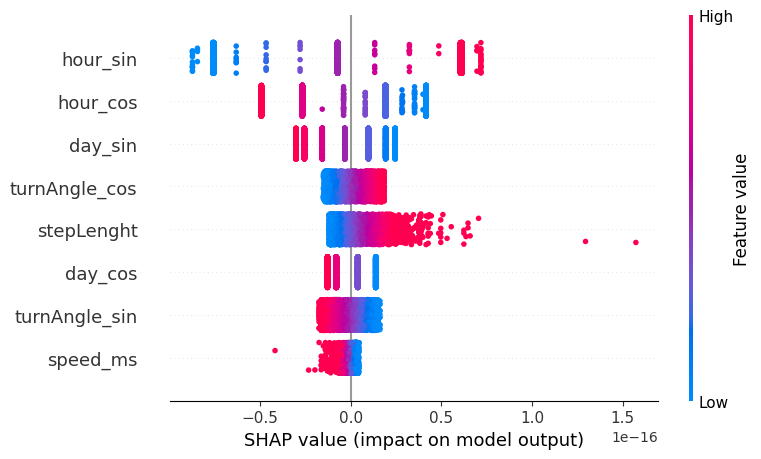

In [10]:
import shap

explainer = shap.Explainer(best_softmax_model, X_train)
shap_values = explainer(X_test)

# Average SHAP values across classes for a global interpretation
shap_values_mean = shap_values.values.mean(axis=2)

# Summary plot with averaged SHAP values and feature names
shap.summary_plot(shap_values_mean, X_test, feature_names=X_test.columns)

Random Forest model

Preprocessing

In [11]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    matthews_corrcoef
)
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import drive

# Mount Google Drive to access data and save results
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Drive is already mounted.")

# Create an output directory for saving model results
output_dir = "/content/drive/MyDrive/Model_results/Synthetic_RF/"
os.makedirs(output_dir, exist_ok=True)

# Load the synthetic dataset generated in the second script
synthetic_data = pd.read_csv("/content/drive/MyDrive/data/synthetic_data.csv")

# Define feature columns used for training and testing the model
feature_columns = [
    'speed_ms', 'stepLenght', 'turnAngle_sin', 'turnAngle_cos',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
] + list(synthetic_data.columns[8:31])  # Include synthetic one-hot-encoded features

# Define target column that represents the class labels
target_column = 'target_class'

# Map class labels to numerical values for compatibility with sklearn models
unique_classes = synthetic_data[target_column].unique()  # Extract unique classes
class_mapping = {class_name: idx for idx, class_name in enumerate(sorted(unique_classes))}  # Create mapping
synthetic_data[target_column] = synthetic_data[target_column].map(class_mapping)  # Apply mapping

# Split the synthetic data into features and target
X_synthetic = synthetic_data[feature_columns]  # Features
y_synthetic = synthetic_data[target_column]  # Target

# Split the data into training and test sets for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_synthetic, y_synthetic, test_size=0.2, random_state=42, stratify=y_synthetic
)

# Print dataset shapes to verify splits
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

# Set up StratifiedGroupKFold for cross-validation to ensure balanced class distributions in folds
n_splits = 16  # Number of folds
cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define a parameter grid for hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100],  # Number of trees in the forest
    'max_depth': [10, 20],  # Maximum depth of trees
    'min_samples_leaf': [2, 4]  # Minimum samples required in leaf nodes
}

Drive is already mounted.
Training set shape: X_train=(16000, 31), y_train=(16000,)
Test set shape: X_test=(4000, 31), y_test=(4000,)


Initialise the model and perform the GridSearchCV

In [13]:
# Initialize the Random Forest model with balanced class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform grid search cross-validation for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv.split(X_train, y_train, groups=None),  # Use StratifiedGroupKFold
    scoring='accuracy',
    n_jobs=-1  # Use all available cores for computation
)

grid_search.fit(X_train, y_train)  # Train the model using grid search

# Save the best model obtained from GridSearchCV
best_model = grid_search.best_estimator_
joblib.dump(best_model, os.path.join(output_dir, "best_rf_model.pkl"))


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


['/content/drive/MyDrive/Model_results/Synthetic_RF/best_rf_model.pkl']

Training the model with the best hyperparameters using a crossvalidation

In [17]:
# Evaluate the model using cross-validation
fold_accuracies = []  # Store accuracy for each fold
fold_mcc_scores = []  # Store MCC for each fold
all_y_true = []  # Collect true labels from all folds
all_y_pred = []  # Collect predictions from all folds

# Reset indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Use StratifiedKFold for cross-validation
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Validate each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    print(f"Fold {fold + 1}: Train indices {train_idx}, Val indices {val_idx}")

    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Check if the validation set is empty
    if X_val_fold.empty:
        print(f"Warning: Fold {fold + 1} has an empty validation set. Skipping this fold.")
        continue  # Skip this fold and move to the next one

    # Train the model on the current fold
    best_model.fit(X_train_fold, y_train_fold)

    # Make predictions for validation set
    y_val_pred = best_model.predict(X_val_fold)

    # Append true and predicted labels for overall metrics
    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_val_pred)

    # Calculate metrics for this fold
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    mcc = matthews_corrcoef(y_val_fold, y_val_pred)
    fold_accuracies.append(accuracy)
    fold_mcc_scores.append(mcc)

Fold 1: Train indices [    0     1     2 ... 15997 15998 15999], Val indices [    5    13    20 ... 15964 15992 15996]
Fold 2: Train indices [    0     1     2 ... 15997 15998 15999], Val indices [    3     7     9 ... 15991 15993 15995]
Fold 3: Train indices [    1     2     3 ... 15996 15997 15999], Val indices [    0     8    21 ... 15989 15994 15998]
Fold 4: Train indices [    0     1     2 ... 15996 15998 15999], Val indices [   12    14    15 ... 15977 15985 15997]
Fold 5: Train indices [    0     3     5 ... 15996 15997 15998], Val indices [    1     2     4 ... 15988 15990 15999]


Save performance metrics

Mean CV Accuracy: 0.24
Mean CV MCC: 0.01
Evaluating on the test set...
Test Accuracy: 0.25
Test MCC: 0.01


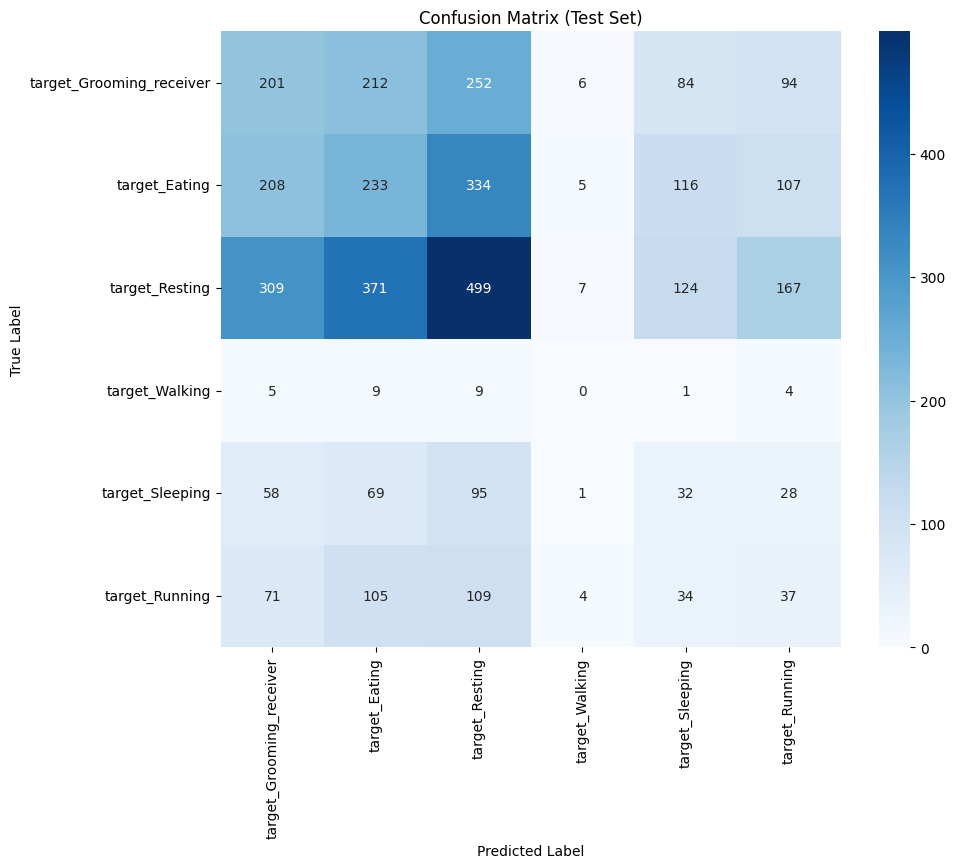

<ipython-input-18-dfb36ff7c5e0>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


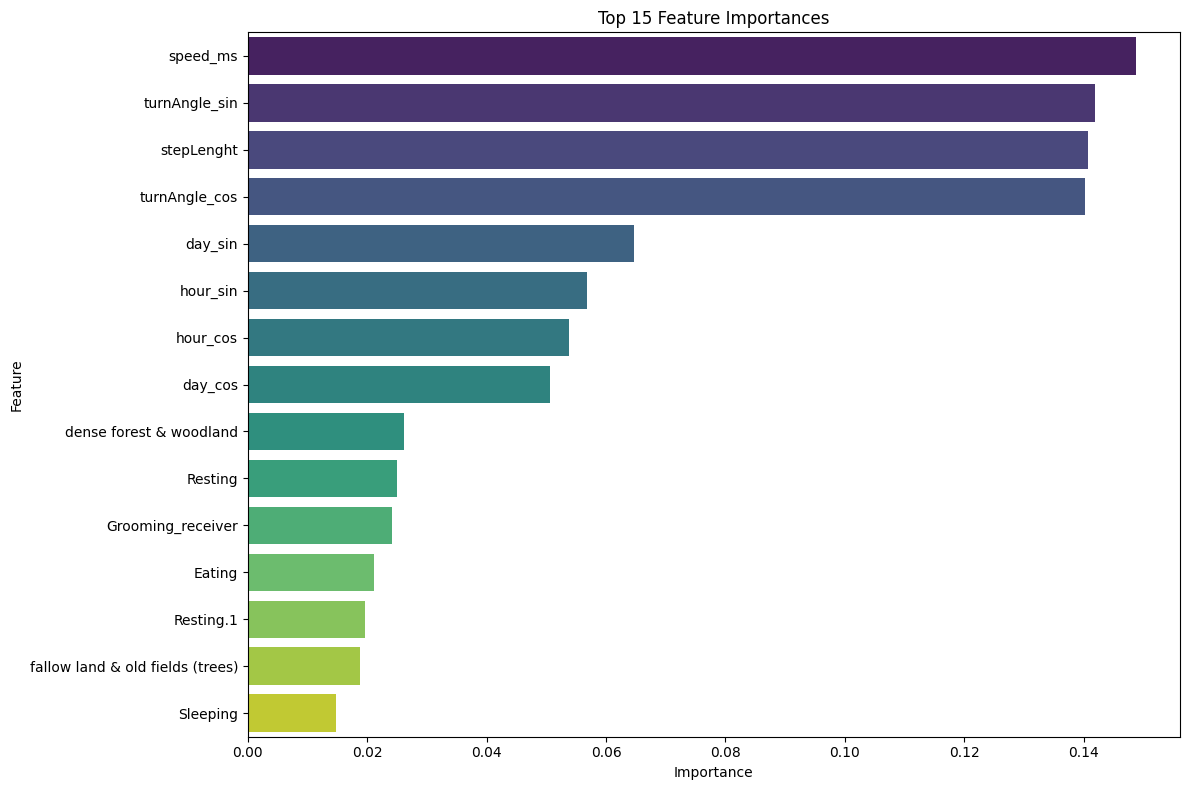

In [18]:
# Calculate overall metrics across all folds
overall_accuracy = np.mean(fold_accuracies)  # Mean accuracy
overall_mcc = np.mean(fold_mcc_scores)  # Mean MCC

# Print cross-validation results
print(f"Mean CV Accuracy: {overall_accuracy:.2f}")
print(f"Mean CV MCC: {overall_mcc:.2f}")

# Evaluate the model on the independent test set
print("Evaluating on the test set...")
y_test_pred = best_model.predict(X_test)  # Make predictions on test data
test_accuracy = accuracy_score(y_test, y_test_pred)  # Test accuracy
test_mcc = matthews_corrcoef(y_test, y_test_pred)  # Test MCC

# Print test results
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test MCC: {test_mcc:.2f}")

# Save confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred, labels=range(len(unique_classes)))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.title("Confusion Matrix (Test Set)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
conf_matrix_path = os.path.join(output_dir, "test_confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.show()

# Save feature importances plot
importances = best_model.feature_importances_  # Feature importances from the model
sorted_indices = np.argsort(importances)[::-1]  # Sort indices by importance (descending)
plt.figure(figsize=(12, 8))
sns.barplot(
    x=importances[sorted_indices][:15],
    y=np.array(feature_columns)[sorted_indices][:15],
    palette="viridis"
)
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
feature_importance_path = os.path.join(output_dir, "feature_importances.png")
plt.savefig(feature_importance_path)
plt.show()


SHAP values and figure


100%|===================| 23950/24000 [04:06<00:00]       

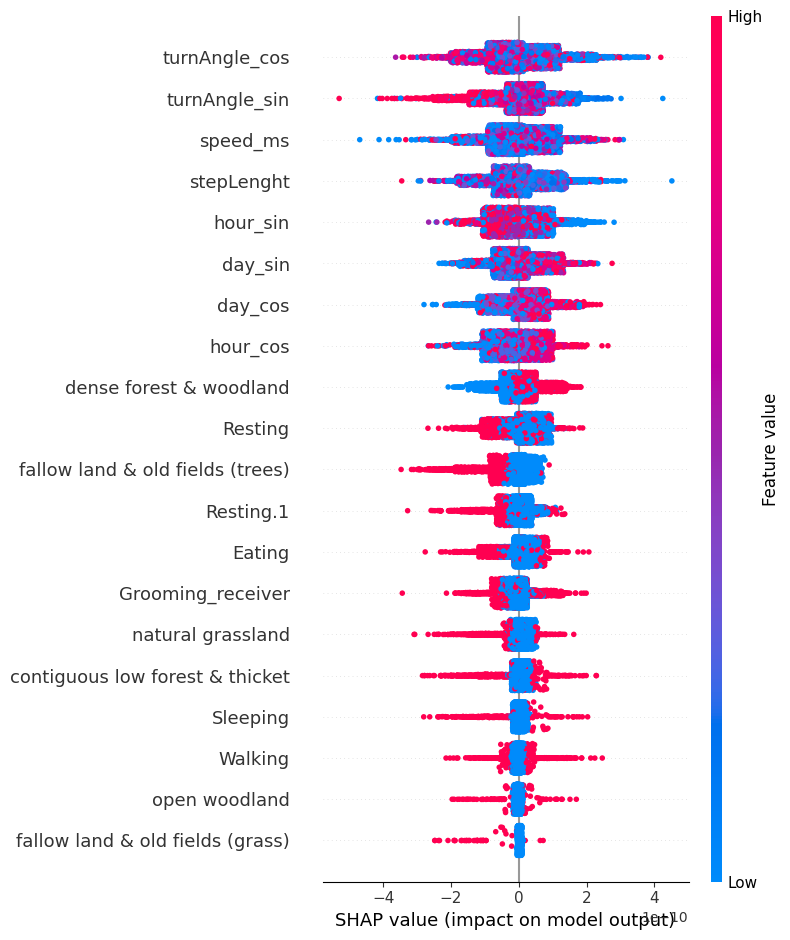

In [22]:
import shap

# Initialize the explainer without check_additivity
explainer = shap.Explainer(best_model, X_train)
# Disable the additivity check within the 'shap_values' calculation
shap_values = explainer(X_test, check_additivity=False)

# Average SHAP values across classes for a global interpretation
shap_values_mean = shap_values.values.mean(axis=2)

# Summary plot with averaged SHAP values and feature names
shap.summary_plot(shap_values_mean, X_test, feature_names=X_test.columns)